In [2]:
import numpy as np
import pandas as pd

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

Matplotlib version:  3.3.0
Libraries imported


We will read the data
We will only take crimes or crimes of the year 2016 due to the large amount of data that I avoid processing all.

In [3]:
vnc_crime_df = pd.read_csv('vancouver_crime_records_2016.csv', index_col=None)

#Dropping X,Y which represents Lat, Lng data as Coordinates, the data seems to be corrupt
vnc_crime_df.drop(['Unnamed: 0','MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)

#vnc_crime_df.columns

vnc_crime_df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,NEIGHBOURHOOD
0,Break and Enter Commercial,2016,3,2,6,West End
1,Break and Enter Commercial,2016,6,16,18,West End
2,Break and Enter Commercial,2016,12,12,0,West End
3,Break and Enter Commercial,2016,4,9,6,Central Business District
4,Break and Enter Commercial,2016,10,2,18,Central Business District


For a better presentation we will change the names of the titles to lowercase with the function .columns

In [4]:
vnc_crime_df.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood']
vnc_crime_df.head()

,Type,Year,Month,Day,Hour,Neighbourhood
0,Break and Enter Commercial,2016,3,2,6,West End
1,Break and Enter Commercial,2016,6,16,18,West End
2,Break and Enter Commercial,2016,12,12,0,West End
3,Break and Enter Commercial,2016,4,9,6,Central Business District
4,Break and Enter Commercial,2016,10,2,18,Central Business District


Now we will see the total of crimes in different neighborhoods using the function .value_counts

In [5]:
vnc_crime_df['Neighbourhood'].value_counts()

Central Business District    10692
West End                      3009
Mount Pleasant                2393
Strathcona                    1982
Kitsilano                     1799
Fairview                      1791
Renfrew-Collingwood           1762
Grandview-Woodland            1757
Kensington-Cedar Cottage      1388
Hastings-Sunrise              1268
Sunset                         967
Riley Park                     866
Marpole                        826
Victoria-Fraserview            599
Killarney                      565
Oakridge                       499
Dunbar-Southlands              474
Kerrisdale                     417
Shaughnessy                    412
West Point Grey                372
Arbutus Ridge                  311
South Cambie                   291
Stanley Park                   154
Musqueam                        17
Name: Neighbourhood, dtype: int64

Second Part: We will get neighborhood information from the wikipedia page to be able to classify your real neighborhood so a neighborhood dictionary based on Wikipedia data will be created.

In [6]:
# define the dataframe columns
column_names = ['Neighbourhood', 'Borough'] 

# instantiate the dataframe
vnc_neigh_bor = pd.DataFrame(columns=column_names)

vnc_neigh_bor['Neighbourhood'] = vnc_crime_df['Neighbourhood'].unique()

neigh_bor_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neigh_bor_dict, vnc_neigh_bor['Neighbourhood']):
  vnc_neigh_bor.loc[vnc_neigh_bor.Neighbourhood == row, 'Borough'] = neigh_bor_dict.get(row)

vnc_neigh_bor.dropna(inplace=True)

print("Total Neighbourhood Count",len(vnc_neigh_bor['Neighbourhood']),"Borough Count",len(vnc_neigh_bor['Borough'].unique()))

vnc_neigh_bor.head()

Total Neighbourhood Count 24 Borough Count 4


,Neighbourhood,Borough
0,West End,Central
1,Central Business District,Central
2,Hastings-Sunrise,East Side
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


Now we will join the tables to include the municipalities.

In [7]:
vnc_boroughs_crime = pd.merge(vnc_crime_df,vnc_neigh_bor, on='Neighbourhood')

vnc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Borough
0,Break and Enter Commercial,2016,3,2,6,West End,Central
1,Break and Enter Commercial,2016,6,16,18,West End,Central
2,Break and Enter Commercial,2016,12,12,0,West End,Central
3,Break and Enter Commercial,2016,3,2,3,West End,Central
4,Break and Enter Commercial,2016,3,17,11,West End,Central


We will clean the data with invalid information with the .dropna function

In [8]:
vnc_boroughs_crime.dropna(inplace=True)
vnc_boroughs_crime['Borough'].value_counts()

Central            13855
East Side          12383
West Side           7192
South Vancouver     1181
Name: Borough, dtype: int64

Applying Methodology
The classification was determined in 2 parts:

Modeling: This way we can provide correct information to citizens within a municipality, similar neighborhoods will be grouped using K-means which is an unsupervised machine learning algorithm that groups data based on a predefined cluster size. The K-Means grouping will be used to identify the security problem that will help citizens to make a decision.

Exploratory data analysis: It will allow to identify and / or visualize crimes in different districts of Vancouver to examine the most secure and insecure.


We will rotate the table to better understand the data by crime and by municipality using the pivot_table function

In [9]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                674                               184   
East Side                              777                              1035   
South Vancouver                         49                               155   
West Side                              396                               995   
All                                   1896                              2369   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2220        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5661        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    13855  
East Side                                                      660    12383  
South Vancouver                                                111     1181  
West Side                                                      389     7192  
All                                                           1474    34611

We join the pivoted column with other columns.

In [10]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,674,184,2220,2489,6871,857,245,1,314,13855
1,East Side,777,1035,2192,1674,4754,678,605,8,660,12383
2,South Vancouver,49,155,187,88,483,36,71,1,111,1181
3,West Side,396,995,1062,696,2838,588,225,3,389,7192


We rotate the table again to better analyze the data.

In [11]:
vnc_crime_neigh = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_neigh

Year  \
Type                      Break and Enter Commercial   
Neighbourhood                                          
Arbutus Ridge                                     12   
Central Business District                        450   
Dunbar-Southlands                                  8   
Fairview                                         134   
Grandview-Woodland                               146   
Hastings-Sunrise                                  47   
Kensington-Cedar Cottage                          62   
Kerrisdale                                        24   
Killarney                                         34   
Kitsilano                                        106   
Marpole                                           42   
Mount Pleasant                                   202   
Musqueam                                           0   
Oakridge                                          19   
Renfrew-Collingwood                               91   
Riley Park                                        35   
Shaughnessy                                       12   
South Cambie                                      21   
Stanley Park                                       6   
Strathcona                                       157   
Sunset                                            37   
Victoria-Fraserview                               15   
West End                                         218   
West Point Grey                                   18   
All                                             1896   

                                                                      \
Type                      Break and Enter Residential/Other Mischief   
Neighbourhood                                                          
Arbutus Ridge                                            78       49   
Central Business District                               111     1761   
Dunbar-Southlands                                       106       81   
Fairview                                                 73      233   
Grandview-Woodland                                      160      304   
Hastings-Sunrise                                        116      195   
Kensington-Cedar Cottage                                142      255   
Kerrisdale                                               97       49   
Killarney                                                72       90   
Kitsilano                                               162      320   
Marpole                                                 125      134   
Mount Pleasant                                          124      353   
Musqueam                                                  4        3   
Oakridge                                                123       64   
Renfrew-Collingwood                                     156      243   
Riley Park                                              122      140   
Shaughnessy                                             118       41   
South Cambie                                             42       41   
Stanley Park                                              2        8   
Strathcona                                              122      527   
Sunset                                                   93      175   
Victoria-Fraserview                                      79       94   
West End                                                 71      451   
West Point Grey                                          71       50   
All                                                    2369     5661   

                                                                           \
Type                      Other Theft Theft from Vehicle Theft of Bicycle   
Neighbourhood                                                               
Arbutus Ridge                      18                111               12   
Central Business District        2034               5301              640   
Dunbar-Southlands                  31                199               16   


We rotate the table again.

In [12]:
vnc_crime_neigh.reset_index(inplace = True)
vnc_crime_neigh.columns = vnc_crime_neigh.columns.map(''.join)
vnc_crime_neigh.rename(columns={'YearAll':'Total'}, inplace=True)

vnc_crime_neigh.head()

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
1,Central Business District,450,111,1761,2034,5301,640,165,0,230,10692
2,Dunbar-Southlands,8,106,81,31,199,16,9,1,23,474
3,Fairview,134,73,233,297,692,245,55,0,62,1791
4,Grandview-Woodland,146,160,304,215,634,110,123,0,65,1757


The describe () function is used to view some basic statistical details such as percentile, mean, standard, etc. of a data frame or a series of numerical values.

In [13]:
vnc_crime_cat.describe()

,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,474.000000,592.250000,1415.250000,1236.750000,3736.500000,539.750000,286.500000,3.250000,368.500000,8652.750000
std,325.841475,488.566185,980.535016,1060.087221,2723.536977,353.955153,226.117226,3.304038,227.060198,5742.792838
min,49.000000,155.000000,187.000000,88.000000,483.000000,36.000000,71.000000,1.000000,111.000000,1181.000000
25%,309.250000,176.750000,843.250000,544.000000,2249.250000,450.000000,186.500000,1.000000,263.250000,5689.250000
50%,535.000000,589.500000,1627.000000,1185.000000,3796.000000,633.000000,235.000000,2.000000,351.500000,9787.500000
75%,699.750000,1005.000000,2199.000000,1877.750000,5283.250000,722.750000,335.000000,4.250000,456.750000,12751.000000
max,777.000000,1035.000000,2220.000000,2489.000000,6871.000000,857.000000,605.000000,8.000000,660.000000,13855.000000


Exploring and ordering the data by crime and by neighborhood.

In [14]:
vnc_crime_neigh.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = vnc_crime_neigh.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
1,Central Business District,450,111,1761,2034,5301,640,165,0,230,10692
22,West End,218,71,451,455,1461,203,77,1,72,3009
11,Mount Pleasant,202,124,353,493,822,232,67,0,100,2393
19,Strathcona,157,122,527,81,821,108,76,2,88,1982
9,Kitsilano,106,162,320,154,755,189,51,1,61,1799


Five neighborhoods with the highest crime rates.

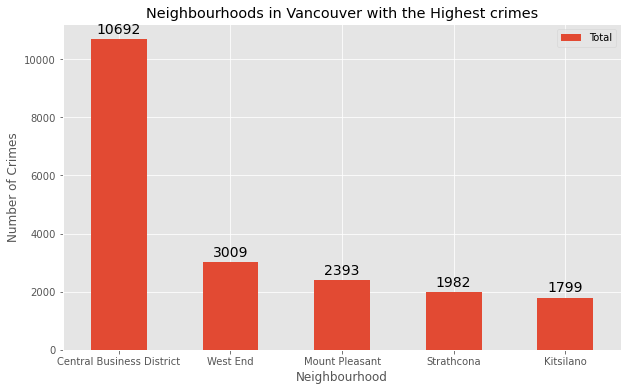

In [15]:
per_neigh = crime_neigh_top5[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

Five neighborhoods with less crime.

In [16]:
crime_neigh_low = vnc_crime_neigh.tail(5)
crime_neigh_low

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
23,West Point Grey,18,71,50,11,157,32,11,0,22,372
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
17,South Cambie,21,42,41,38,111,19,8,0,11,291
18,Stanley Park,6,2,8,0,109,14,3,0,12,154
12,Musqueam,0,4,3,0,4,2,2,0,2,17


Now we show it graphically.

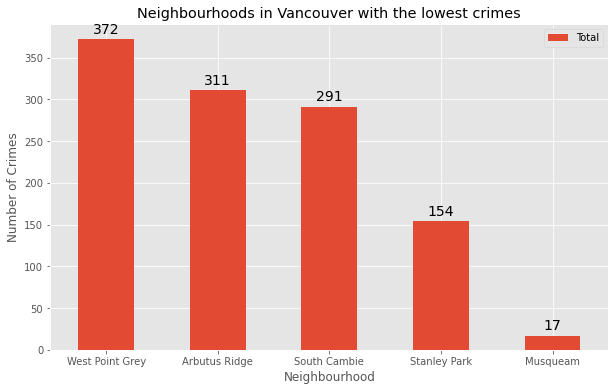

In [17]:
per_neigh = crime_neigh_low[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

Borough is Vancouver with highest crime.

In [18]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                674                               184   
East Side                              777                              1035   
South Vancouver                         49                               155   
West Side                              396                               995   
All                                   1896                              2369   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2220        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5661        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    13855  
East Side                                                      660    12383  
South Vancouver                                                111     1181  
West Side                                                      389     7192  
All                                                           1474    34611

In [19]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,Break and Enter Commercial,Break and Enter Residential,Mischief,Other,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,674,184,2220,2489,6871,857,245,1,314,13855
1,East Side,777,1035,2192,1674,4754,678,605,8,660,12383
2,South Vancouver,49,155,187,88,483,36,71,1,111,1181
3,West Side,396,995,1062,696,2838,588,225,3,389,7192


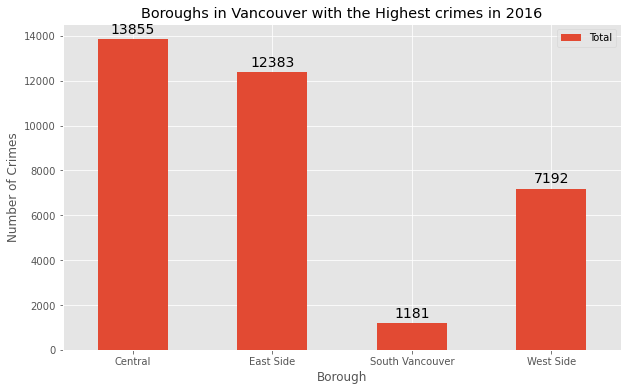

In [20]:
per_borough = vnc_crime_cat[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes in 2016')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

As can be seen from the data exploration analysis we can identify that South Vancouver has the safest neighborhoods where the crime rate is the lowest and it is more where citizens can feel safer.

In the following graph we can determine that despite the low crime rate in South Vancouver the crimes of 'Mischief' and 'Other' are low for a citizen on foot.

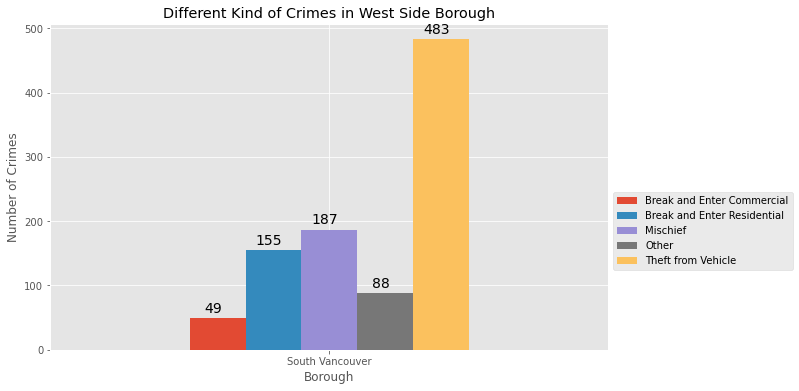

In [21]:
vnc_ws_df = vnc_crime_cat[vnc_crime_cat['Borough'] == 'South Vancouver']

vnc_ws_df = vnc_ws_df.sort_values(['Total'], ascending = True, axis = 0)

vnc_ws = vnc_ws_df[['Borough', 'Break and Enter Commercial','Break and Enter Residential','Mischief','Other',
                 'Theft from Vehicle']]


vnc_ws.set_index('Borough',inplace = True)

ax = vnc_ws.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Different Kind of Crimes in West Side Borough')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

Third part:
Create a new consolidated data set of Neighborhoods, along with their districts, crime data, and the coordinates of the respective neighborhood:
This data will be obtained using OpenCage Geocoder to find the safest district and explore the neighborhood by mapping it using Folium and performing exploratory data analysis.
Restrict rows in the data frame to only those with the west side such as Borough

In [22]:
vnc_ws_neigh = vnc_boroughs_crime

#vnc_ws_neigh.drop(['Type','Year', 'Month', 'Day', 'Hour'], axis = 1, inplace = True)
vnc_ws_neigh = vnc_ws_neigh[vnc_ws_neigh['Borough'] == 'West Side']
vnc_ws_neigh.reset_index(inplace=True, drop=True)

print('Number of Neighbourhoods in West Side Borough', len(vnc_ws_neigh['Neighbourhood'].unique()))

vnc_ws_neigh['Neighbourhood'].unique()

Number of Neighbourhoods in West Side Borough 10


array(['Shaughnessy', 'Fairview', 'Oakridge', 'Marpole', 'Kitsilano',
       'Kerrisdale', 'West Point Grey', 'Arbutus Ridge', 'South Cambie',
       'Dunbar-Southlands'], dtype=object)

Now the next thing is to make with Lat Lng a data frame with an Opecage geocoder

In [23]:
Latitude = []
Longitude = []
Borough = []
Neighbourhood = vnc_ws_neigh['Neighbourhood'].unique()



key = '830323b5ca694362904814ff0a11b803'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighbourhood)):
    address = '{}, Vancouver, BC, Canada'.format(Neighbourhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('West Side')
print(Latitude, Longitude)

#print('The geograpical coordinate of Vancouver City are {}, {}.'.format(latitude, longitude))

[49.2518626, 49.2641128, 49.2308288, 49.2092233, 49.2694099, 49.2346728, 49.2644843, 49.2409677, 49.2466847, 49.2534601] [-123.1380226, -123.1268352, -123.1311342, -123.1361495, -123.155267, -123.1553893, -123.1854326, -123.1670008, -123.120915, -123.1850439]


We will now take a look at the West Side neighborhoods with their coordinates.

In [24]:
ws_neig_dict = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
ws_neig_geo = pd.DataFrame(data=ws_neig_dict, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

ws_neig_geo

,Neighbourhood,Borough,Latitude,Longitude
0,Shaughnessy,West Side,49.251863,-123.138023
1,Fairview,West Side,49.264113,-123.126835
2,Oakridge,West Side,49.230829,-123.131134
3,Marpole,West Side,49.209223,-123.136150
4,Kitsilano,West Side,49.269410,-123.155267
5,Kerrisdale,West Side,49.234673,-123.155389
6,West Point Grey,West Side,49.264484,-123.185433
7,Arbutus Ridge,West Side,49.240968,-123.167001
8,South Cambie,West Side,49.246685,-123.120915
9,Dunbar-Southlands,West Side,49.253460,-123.185044


Now we will trace the coordinates of Vancouver on the map.

In [25]:
address = 'Vancouver, BC, Canada'

location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

print('The geograpical coordinate of Vancouver, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver, Canada are 49.2608724, -123.1139529.


In this opportunity we will now use Folium to make the respective crossing.

In [26]:
van_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(ws_neig_geo['Latitude'], ws_neig_geo['Longitude'], ws_neig_geo['Borough'], ws_neig_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(van_map)  
    
van_map

Last Part: We will obtain data through the Four Squere API to carry out a more in-depth exploration and we will apply machine learning to group neighborhoods. And we will use Folium to plot them on maps.

In [27]:
#Four Square Credentials

CLIENT_ID = 'XVY0YGK3DX5QGHMN2TGSK2EWA55P3JNPIVC5QVW5SGIGUI2L'
CLIENT_SECRET = 'T53Z3HT4W5DVALRIPBK2DPD4NFOCISMUTMNBLNW13KEJTAIJ'
VERSION = '20191101'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XVY0YGK3DX5QGHMN2TGSK2EWA55P3JNPIVC5QVW5SGIGUI2L
CLIENT_SECRET:T53Z3HT4W5DVALRIPBK2DPD4NFOCISMUTMNBLNW13KEJTAIJ


To find the places in a given neighborhood we need a function.

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
vnc_ws_venues = getNearbyVenues(names=ws_neig_geo['Neighbourhood'],
                                   latitudes=ws_neig_geo['Latitude'],
                                   longitudes=ws_neig_geo['Longitude']
                                  )

Shaughnessy
Fairview
Oakridge
Marpole
Kitsilano
Kerrisdale
West Point Grey
Arbutus Ridge
South Cambie
Dunbar-Southlands


We will see a list that contains the places of each neighborhood.

In [30]:
print(vnc_ws_venues.shape)
vnc_ws_venues.head()

(231, 5)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,Shaughnessy,49.251863,-123.138023,Bus Stop 50209 (10),Bus Stop
1,Shaughnessy,49.251863,-123.138023,Angus Park,Park
2,Shaughnessy,49.251863,-123.138023,Crepe & Cafe,French Restaurant
3,Fairview,49.264113,-123.126835,Gyu-Kaku Japanese BBQ,BBQ Joint
4,Fairview,49.264113,-123.126835,CRESCENT nail and spa,Nail Salon


To carry out the modeling we will make an active coding of each neighborhood.

In [31]:
# one hot encoding
vnc_onehot = pd.get_dummies(vnc_ws_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vnc_onehot['Neighbourhood'] = vnc_ws_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [vnc_onehot.columns[-1]] + list(vnc_onehot.columns[:-1])
vnc_onehot = vnc_onehot[fixed_columns]

vnc_onehot.head()

,Neighbourhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,Boutique,...,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Wine Shop,Yoga Studio
0,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fairview,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
vnc_ws_grouped = vnc_onehot.groupby('Neighbourhood').mean().reset_index()
vnc_ws_grouped

,Neighbourhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,Boutique,...,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Wine Shop,Yoga Studio
0,Arbutus Ridge,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Dunbar-Southlands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Fairview,0.000000,0.076923,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.038462,0.000000,0.000000
3,Kerrisdale,0.000000,0.025000,0.000000,0.025000,0.050000,0.000000,0.000000,0.000000,0.025,...,0.000000,0.050000,0.000000,0.025000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000
4,Kitsilano,0.043478,0.021739,0.000000,0.086957,0.000000,0.000000,0.021739,0.000000,0.000,...,0.000000,0.021739,0.021739,0.043478,0.000000,0.021739,0.000000,0.000000,0.000000,0.021739
5,Marpole,0.000000,0.000000,0.000000,0.000000,0.032258,0.032258,0.000000,0.000000,0.000,...,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000
6,Oakridge,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000
7,Shaughnessy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,South Cambie,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,West Point Grey,0.000000,0.021739,0.000000,0.043478,0.021739,0.021739,0.000000,0.043478,0.000,...,0.000000,0.000000,0.000000,0.000000,0.021739,0.043478,0.000000,0.000000,0.021739,0.021739


In [33]:
vnc_ws_grouped.shape

(10, 91)

The most common or crowded places.

In [34]:
num_top_venues = 8

for hood in vnc_ws_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = vnc_ws_grouped[vnc_ws_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arbutus Ridge----
                   venue  freq
0          Grocery Store   0.2
1                 Bakery   0.2
2         Nightlife Spot   0.2
3                    Spa   0.2
4              Pet Store   0.2
5  Performing Arts Venue   0.0
6            Record Shop   0.0
7                    Pub   0.0


----Dunbar-Southlands----
                   venue  freq
0       Sushi Restaurant  0.25
1     Salon / Barbershop  0.12
2            Coffee Shop  0.12
3     Italian Restaurant  0.12
4      Indian Restaurant  0.12
5         Ice Cream Shop  0.12
6    Sporting Goods Shop  0.12
7  Performing Arts Venue  0.00


----Fairview----
                 venue  freq
0          Coffee Shop  0.15
1     Asian Restaurant  0.08
2                 Park  0.08
3   Salon / Barbershop  0.04
4         Camera Store  0.04
5     Malay Restaurant  0.04
6    Korean Restaurant  0.04
7  Japanese Restaurant  0.04


----Kerrisdale----
                venue  freq
0         Coffee Shop  0.10
1  Chinese Restaurant  0.08
2      

Let's visualize the best places in a new data frame.

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = vnc_ws_grouped['Neighbourhood']

for ind in np.arange(vnc_ws_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vnc_ws_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Nightlife Spot,Spa,Bakery,Grocery Store,Pet Store,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant
1,Dunbar-Southlands,Sushi Restaurant,Sporting Goods Shop,Ice Cream Shop,Salon / Barbershop,Coffee Shop,Italian Restaurant,Indian Restaurant,Hobby Shop,Falafel Restaurant,Convenience Store
2,Fairview,Coffee Shop,Park,Asian Restaurant,Sandwich Place,Pharmacy,Nail Salon,Camera Store,Diner,Restaurant,Falafel Restaurant
3,Kerrisdale,Coffee Shop,Chinese Restaurant,Sandwich Place,Sushi Restaurant,Pharmacy,Bank,Tea Room,Gym Pool,Pizza Place,Pet Store
4,Kitsilano,Bakery,American Restaurant,Coffee Shop,Japanese Restaurant,Ice Cream Shop,French Restaurant,Sushi Restaurant,Food Truck,Thai Restaurant,Clothing Store


Cluster of Neighbourhoods

In [39]:
# set number of clusters
kclusters = 5

vnc_grouped_clustering = vnc_ws_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vnc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 0, 0, 0, 0, 3, 2, 0, 0], dtype=int32)

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = ws_neig_geo

# merge toronto_grouped with Vancouver data to add latitude/longitude for each neighborhood
vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

vancouver_merged.head()

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shaughnessy,West Side,49.251863,-123.138023,2,Park,Bus Stop,French Restaurant,Yoga Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant
1,Fairview,West Side,49.264113,-123.126835,0,Coffee Shop,Park,Asian Restaurant,Sandwich Place,Pharmacy,Nail Salon,Camera Store,Diner,Restaurant,Falafel Restaurant
2,Oakridge,West Side,49.230829,-123.131134,3,Bubble Tea Shop,Sushi Restaurant,Pharmacy,Sandwich Place,Fast Food Restaurant,Convenience Store,Concert Hall,Vietnamese Restaurant,Gym Pool,Falafel Restaurant
3,Marpole,West Side,49.209223,-123.136150,0,Sushi Restaurant,Bubble Tea Shop,Pizza Place,Chinese Restaurant,Bus Stop,Sandwich Place,Gas Station,Dessert Shop,Plaza,Dim Sum Restaurant
4,Kitsilano,West Side,49.269410,-123.155267,0,Bakery,American Restaurant,Coffee Shop,Japanese Restaurant,Ice Cream Shop,French Restaurant,Sushi Restaurant,Food Truck,Thai Restaurant,Clothing Store


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighbourhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Analyzing the results of the clusters

In [42]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 4, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,West Side,Sushi Restaurant,Sporting Goods Shop,Ice Cream Shop,Salon / Barbershop,Coffee Shop,Italian Restaurant,Indian Restaurant,Hobby Shop,Falafel Restaurant,Convenience Store


In [43]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 2, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Side,Park,Bus Stop,French Restaurant,Yoga Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant


In [44]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 0, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,West Side,Coffee Shop,Park,Asian Restaurant,Sandwich Place,Pharmacy,Nail Salon,Camera Store,Diner,Restaurant,Falafel Restaurant
3,West Side,Sushi Restaurant,Bubble Tea Shop,Pizza Place,Chinese Restaurant,Bus Stop,Sandwich Place,Gas Station,Dessert Shop,Plaza,Dim Sum Restaurant
4,West Side,Bakery,American Restaurant,Coffee Shop,Japanese Restaurant,Ice Cream Shop,French Restaurant,Sushi Restaurant,Food Truck,Thai Restaurant,Clothing Store
5,West Side,Coffee Shop,Chinese Restaurant,Sandwich Place,Sushi Restaurant,Pharmacy,Bank,Tea Room,Gym Pool,Pizza Place,Pet Store
6,West Side,Coffee Shop,Japanese Restaurant,Café,Sushi Restaurant,Pizza Place,Bakery,Vegetarian / Vegan Restaurant,Bookstore,Pub,Gastropub
8,West Side,Coffee Shop,Bus Stop,Sushi Restaurant,Malay Restaurant,Grocery Store,Park,Cantonese Restaurant,Café,Cafeteria,Shopping Mall


Discussion
The goal of the problem was to help citizens identify safer places in Vancouver so that they can be quietly with their children in one place. But in his view it was also observed that in the West part of Vancouver there are not very criminal places but also more crowded than in the South. Thanks to the criminal information we detected that the least criminal places with both South and the West part.

Conclusion
In conclusion, I can indicate that both information and technology allow us to establish certain prevention mechanisms to make adequate decisions for the good of citizens.